In [24]:
# Import necessary libraries and settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timezone, timedelta
import pytz
import warnings
warnings.filterwarnings("ignore")

# plotting defaults - seaborn for nicer plots
sns.set(style="whitegrid", context="talk")


**File Paths and Configuration**

In [25]:
# Datasets path
FEAR_GREED_CSV = "fear_greed_index.csv"      # path to fear_greed_index.csv
HISTORICAL_CSV = "historical_data.csv"      # path to historical_data.csv

# Output dirs
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Default timezone for historical trades - dataset shows "Timestamp IST"
LOCAL_TZ = pytz.timezone("Asia/Kolkata")

# Merge strategy: map trades to daily sentiment by date (YYYY-MM-DD).
# If you want minute-level matching later, change this.
MERGE_ON = "date"   # will map historical trades -> trade_date -> date (YYYY-MM-DD)


**Load datasets robustly**

In [26]:
# Read fear & greed index
fg = pd.read_csv(FEAR_GREED_CSV, low_memory=False)
print("Fear/Greed shape:", fg.shape)
display(fg.head(8))
print(fg.columns.tolist())

Fear/Greed shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
5,1517895000,8,Extreme Fear,2018-02-06
6,1517981400,36,Fear,2018-02-07
7,1518067800,30,Fear,2018-02-08


['timestamp', 'value', 'classification', 'date']


In [27]:
# Read historical trades
hist = pd.read_csv(HISTORICAL_CSV, low_memory=False)
print("Historical trades shape:", hist.shape)
display(hist.head(8))
print(hist.columns.tolist())

Historical trades shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,BUY,02-12-2024 22:50,1298.215466,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.000493,7.330000e+14,1.730000e+12
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9934,144.09,1151.77,BUY,02-12-2024 22:50,1299.624972,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,9.060000e+14,1.730000e+12
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,34.00,272.00,BUY,02-12-2024 22:50,1443.664541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.011900,3.960000e+14,1.730000e+12


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [28]:
# Checking is there any null values in the fear and greed index dataset
fg.isnull().sum()

,0
timestamp,0
value,0
classification,0
date,0


In [29]:
# Checking is there any null values in the historical dataset
hist.isnull().sum()

,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


In [30]:
# Basic information about the datasets
fg.info()
print("\n")
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-

Inspect & quick-clean Fear & Greed dataset
Observations to handle:
- 'timestamp' is unix seconds
- 'date' is in DD-MM-YYYY format (string)
- 'value' numeric, 'classification' categorical

In [31]:

# Copy to avoid accidental changes
fg = fg.copy()

# --- 1. Convert timestamp from unix -> UTC datetime ---
if 'timestamp' in fg.columns:
    fg['timestamp'] = pd.to_numeric(fg['timestamp'], errors='coerce')
    fg['datetime_utc'] = pd.to_datetime(fg['timestamp'], unit='s', utc=True)
else:
    fg['datetime_utc'] = pd.NaT

# --- 2. Try parsing 'date' column if it exists ---
if 'date' in fg.columns:
    # Try multiple formats to be safe
    fg['date_parsed'] = pd.to_datetime(fg['date'], errors='coerce', dayfirst=True)
else:
    fg['date_parsed'] = pd.NaT

# --- 3. Fill missing date_parsed from datetime_utc ---
# If we have valid UTC datetimes, convert to local timezone and drop time
LOCAL_TZ = 'Asia/Kolkata'  # Change if needed
fg.loc[fg['date_parsed'].isna() & fg['datetime_utc'].notna(), 'date_parsed'] = (
    fg['datetime_utc']
    .dt.tz_convert(LOCAL_TZ)
    .dt.floor('D')
)

# --- Ensure all date_parsed are pandas datetime64[ns] without timezone ---
fg['date_parsed'] = pd.to_datetime(fg['date_parsed'], utc=True)  # Force tz-aware UTC
fg['date_parsed'] = fg['date_parsed'].dt.tz_convert(None)        # Make tz-naive

# --- 4. Ensure 'value' is numeric ---
fg['value'] = pd.to_numeric(fg['value'], errors='coerce')

# --- 5. Clean classification strings ---
if 'classification' in fg.columns:
    fg['classification'] = fg['classification'].astype(str).str.strip().str.title()

# --- 6. Create merge-friendly string date (YYYY-MM-DD) ---
fg['date'] = fg['date_parsed'].dt.strftime('%Y-%m-%d')

# --- 7. Quick checks ---
print("FG null counts after fix:")
print(fg[['timestamp', 'datetime_utc', 'date_parsed', 'value', 'classification', 'date']].isnull().sum())

print("\nSample cleaned FG data:")
print(fg[['datetime_utc', 'date_parsed', 'date', 'value', 'classification']].head(10))



FG null counts after fix:
timestamp         0
datetime_utc      0
date_parsed       0
value             0
classification    0
date              0
dtype: int64

Sample cleaned FG data:
               datetime_utc date_parsed        date  value classification
0 2018-02-01 05:30:00+00:00  2018-01-02  2018-01-02     30           Fear
1 2018-02-02 05:30:00+00:00  2018-02-02  2018-02-02     15   Extreme Fear
2 2018-02-03 05:30:00+00:00  2018-03-02  2018-03-02     40           Fear
3 2018-02-04 05:30:00+00:00  2018-04-02  2018-04-02     24   Extreme Fear
4 2018-02-05 05:30:00+00:00  2018-05-02  2018-05-02     11   Extreme Fear
5 2018-02-06 05:30:00+00:00  2018-06-02  2018-06-02      8   Extreme Fear
6 2018-02-07 05:30:00+00:00  2018-07-02  2018-07-02     36           Fear
7 2018-02-08 05:30:00+00:00  2018-08-02  2018-08-02     30           Fear
8 2018-02-09 05:30:00+00:00  2018-09-02  2018-09-02     44           Fear
9 2018-02-10 05:30:00+00:00  2018-10-02  2018-10-02     54        Neutral


Inspect & clean historical trades dataset
Observations from sample: columns like 'Timestamp IST' as 'DD-MM-YYYY HH:MM', numeric columns, 'Coin' like '@107'
We'll:
- standardize column names (lowercase, remove spaces)
- parse timestamps with IST timezone
- coerce numeric columns
- extract trade_date for merge

In [32]:
# Normalize column names: lowercase, replace spaces with underscores
hist = hist.rename(columns=lambda x: x.strip().lower().replace(' ', '_').replace('.', '').replace('/', '_'))

# Show columns
print("Columns after normalization:")
print(hist.columns.tolist())

# Identify timestamp column (common names)
possible_ts_cols = [c for c in hist.columns if 'timestamp' in c]
print("Possible timestamp columns:", possible_ts_cols)

Columns after normalization:
['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Possible timestamp columns: ['timestamp_ist', 'timestamp']


In [33]:
# Choose timestamp column (based on your sample it's 'timestamp_ist' or 'timestamp')
if 'timestamp_ist' in hist.columns:
    ts_col = 'timestamp_ist'
elif 'timestamp' in hist.columns:
    ts_col = 'timestamp'
else:
    # fallback: pick first column name containing 'timestamp'
    ts_col = possible_ts_cols[0] if possible_ts_cols else None

print("Using timestamp column:", ts_col)


Using timestamp column: timestamp_ist


In [34]:
# Parse timestamp column into timezone-aware datetimes
def parse_hist_timestamp(s):
    # expected format like '02-12-2024 22:50' (DD-MM-YYYY HH:MM)
    try:
        # first try with day-first
        dt = datetime.strptime(s.strip(), "%d-%m-%Y %H:%M")
        # localize to IST
        return LOCAL_TZ.localize(dt)
    except Exception:
        try:
            # sometimes there may be seconds or different separators
            return pd.to_datetime(s, dayfirst=True, errors='coerce').tz_localize(LOCAL_TZ, ambiguous='NaT')
        except Exception:
            return pd.NaT

if ts_col:
    hist[ts_col+'_parsed'] = hist[ts_col].astype(str).apply(parse_hist_timestamp)
else:
    hist['timestamp_parsed'] = pd.NaT

# create trade_date column (YYYY-MM-DD string) to match fear/greed 'date'
hist['trade_date'] = hist[ts_col + '_parsed'].dt.date.astype('str')

# Coerce numeric columns (common names from sample)
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee', 'start_position']
for c in numeric_cols:
    if c in hist.columns:
        hist[c] = pd.to_numeric(hist[c].astype(str).str.replace(',',''), errors='coerce')

# Clean coin column (remove leading @ if present)
if 'coin' in hist.columns:
    hist['coin'] = hist['coin'].astype(str).str.strip().str.replace('^@', '', regex=True)

# Standardize side column to uppercase
if 'side' in hist.columns:
    hist['side'] = hist['side'].astype(str).str.strip().str.upper()

# Derive additional columns
hist['is_win'] = (hist['closed_pnl'] > 0).astype(int)
hist['pnl_per_usd'] = hist['closed_pnl'] / hist['size_usd']
hist['trade_hour'] = hist[ts_col + '_parsed'].dt.hour

# Quick checks
print("Historical data null counts (selected):")
print(hist[['trade_date', ts_col + '_parsed', 'execution_price', 'size_usd', 'closed_pnl', 'coin', 'side']].isnull().sum())
display(hist.head(8))


Historical data null counts (selected):
trade_date              0
timestamp_ist_parsed    0
execution_price         0
size_usd                0
closed_pnl              0
coin                    0
side                    0
dtype: int64


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp,timestamp_ist_parsed,trade_date,is_win,pnl_per_usd,trade_hour
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9900,1.41,11.27,BUY,02-12-2024 22:50,1298.215466,Buy,0.0,...,52017706630,True,0.000493,7.330000e+14,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9934,144.09,1151.77,BUY,02-12-2024 22:50,1299.624972,Buy,0.0,...,52017706630,True,0.050431,9.060000e+14,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,8.0000,34.00,272.00,BUY,02-12-2024 22:50,1443.664541,Buy,0.0,...,52017706630,True,0.011900,3.960000e+14,1.730000e+12,2024-12-02 22:50:00+05:30,2024-12-02,0,0.0,22


Merge trades with daily sentiment
Strategy:
- For each date in fg, if multiple entries exist in same day, create daily aggregation:
  - numeric sentiment value -> median (or mean)
  - classification -> mode (most frequent). If tie, pick highest severity (custom)

In [35]:
# Aggregate FG per date (daily)
# numeric aggregation: median of 'value'
# classification aggregation: mode (most frequent)
agg_value = fg.groupby('date')['value'].median().rename('fg_value_median').reset_index()
agg_class = fg.groupby('date')['classification'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan).rename('fg_classification_mode').reset_index()

fg_daily = agg_value.merge(agg_class, on='date', how='left')
print("FG daily shape:", fg_daily.shape)
display(fg_daily.head(8))


FG daily shape: (2561, 3)


,date,fg_value_median,fg_classification_mode
0,2018-01-02,30.0,Fear
1,2018-01-03,38.0,Fear
2,2018-01-04,16.0,Extreme Fear
3,2018-01-05,56.0,Greed
4,2018-01-06,24.0,Extreme Fear
5,2018-01-07,27.0,Fear
6,2018-01-08,39.0,Fear
7,2018-01-09,21.0,Extreme Fear


In [36]:
# Merge: attach fg_daily to each trade by trade_date -> date
merged = hist.merge(fg_daily, left_on='trade_date', right_on='date', how='left', indicator=True)
print("Merged shape:", merged.shape)
print("Merge indicator value counts:")
print(merged['_merge'].value_counts())

# Show trades without matched sentiment (if any)
missing_sentiment = merged[merged['fg_value_median'].isnull()].shape[0]
print(f"Trades without daily sentiment mapping: {missing_sentiment}")


Merged shape: (211224, 25)
Merge indicator value counts:
_merge
both          169951
left_only      41273
right_only         0
Name: count, dtype: int64
Trades without daily sentiment mapping: 41273


In [38]:
# Assuming 'merged_df' is your merged DataFrame
# and that 'indicator' column was created with 'merge(..., indicator=True)'

# 1. Filter the left_only rows
missing_sentiment_df = merged[merged['_merge'] == 'left_only'].copy()

# 2. Ensure the date column is in datetime format
missing_sentiment_df['date'] = pd.to_datetime(missing_sentiment_df['date'])

# 3. Get unique missing dates (sorted)
missing_dates = missing_sentiment_df['date'].drop_duplicates().sort_values()

print(f"Number of missing sentiment rows: {len(missing_sentiment_df)}")
print(f"Number of unique missing dates: {len(missing_dates)}")
print("\nSample of missing dates:")
print(missing_dates.head(20))  # Show first 20 dates

# 4. Check if they're weekends
missing_dates_df = pd.DataFrame({
    'date': missing_dates,
    'day_of_week': missing_dates.dt.day_name()
})

print("\nMissing dates with day of week:")
print(missing_dates_df.head(20))

# 5. Check min & max date for coverage gap idea
print("\nMissing date range:", missing_dates.min(), "to", missing_dates.max())


Number of missing sentiment rows: 41273
Number of unique missing dates: 1

Sample of missing dates:
211   NaT
Name: date, dtype: datetime64[ns]

Missing dates with day of week:
    date day_of_week
211  NaT         NaN

Missing date range: NaT to NaT


**Basic exploratory analysis & summary statistics**

In [18]:
# A) High-level counts & date range
total_trades = merged.shape[0]
unique_accounts = merged['account'].nunique() if 'account' in merged.columns else merged['account'].nunique()
unique_coins = merged['coin'].nunique() if 'coin' in merged.columns else None
date_range_trades = (merged[ts_col + '_parsed'].min(), merged[ts_col + '_parsed'].max())

print("Total trades:", total_trades)
print("Unique accounts:", unique_accounts)
print("Unique coins/symbols:", unique_coins)
print("Trade timestamp range:", date_range_trades)


Total trades: 51122
Unique accounts: 10
Unique coins/symbols: 179
Trade timestamp range: (Timestamp('2023-12-05 03:11:00+0530', tz='Asia/Kolkata'), Timestamp('2025-05-01 11:42:00+0530', tz='Asia/Kolkata'))


In [19]:
# B) Summary stats of PnL, by sentiment classification
group_cols = ['fg_classification_mode']  # categories like 'Fear', 'Greed', etc.

agg_funcs = {
    'closed_pnl': ['count', 'sum', 'mean', 'median', 'std'],
    'is_win': ['mean'],           # win rate (mean of 0/1)
    'size_usd': ['mean', 'median'],
    'pnl_per_usd': ['mean', 'median']
}

summary_by_sent = merged.groupby(group_cols).agg(agg_funcs)
# flatten multiindex columns
summary_by_sent.columns = ['_'.join(col).strip() for col in summary_by_sent.columns.values]
summary_by_sent = summary_by_sent.reset_index().sort_values('closed_pnl_sum', ascending=False)
display(summary_by_sent)


,fg_classification_mode,closed_pnl_count,closed_pnl_sum,closed_pnl_mean,closed_pnl_median,closed_pnl_std,is_win_mean,size_usd_mean,size_usd_median,pnl_per_usd_mean,pnl_per_usd_median
1,Extreme Greed,9712,1.815794e+06,186.963953,0.463398,1608.661573,0.517195,7886.798851,1170.000,0.082090,0.002191
2,Fear,11986,1.735142e+06,144.764063,0.000000,1889.084832,0.446938,20581.726381,1187.905,0.024745,0.000000
3,Greed,15464,1.261004e+06,81.544489,0.000000,1490.169099,0.430484,16031.129164,1574.380,0.019487,0.000000
4,Neutral,9331,8.594779e+05,92.109940,0.000000,867.856356,0.459865,10145.353892,1030.250,0.026926,0.000000
0,Extreme Fear,2388,4.281944e+05,179.310907,0.000000,1696.524306,0.433417,8527.280925,999.540,0.035622,0.000000


Visualizations
- Save plots to outputs/ and display inline.

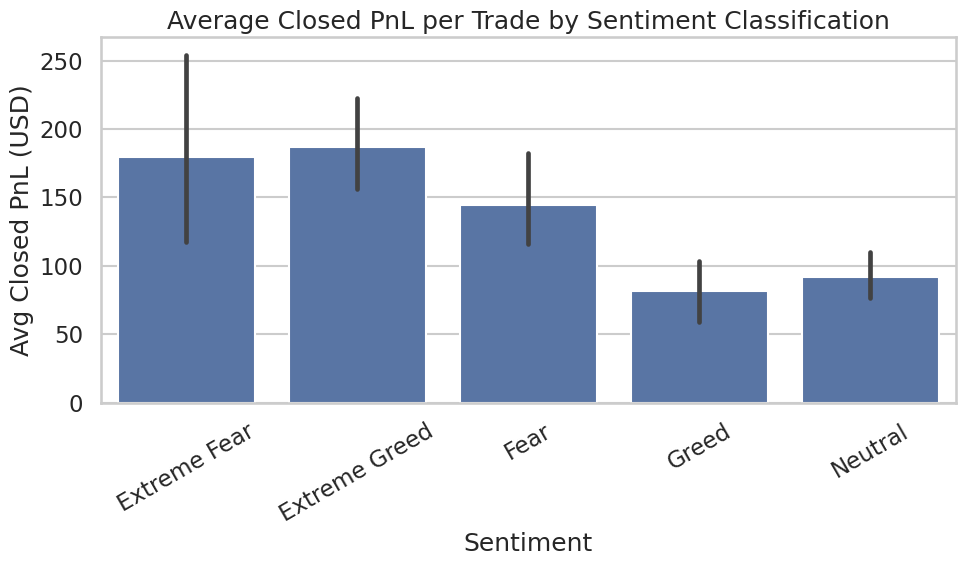

In [20]:
# Helper plot save
def savefig(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.close(fig)

# 7A: Bar chart - avg closed_pnl per sentiment
plt.figure(figsize=(10,6))
sns.barplot(data=merged, x='fg_classification_mode', y='closed_pnl', estimator=np.nanmean, order=sorted(merged['fg_classification_mode'].dropna().unique()))
plt.title("Average Closed PnL per Trade by Sentiment Classification")
plt.ylabel("Avg Closed PnL (USD)")
plt.xlabel("Sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_pnl_by_sentiment.png"))
plt.show()


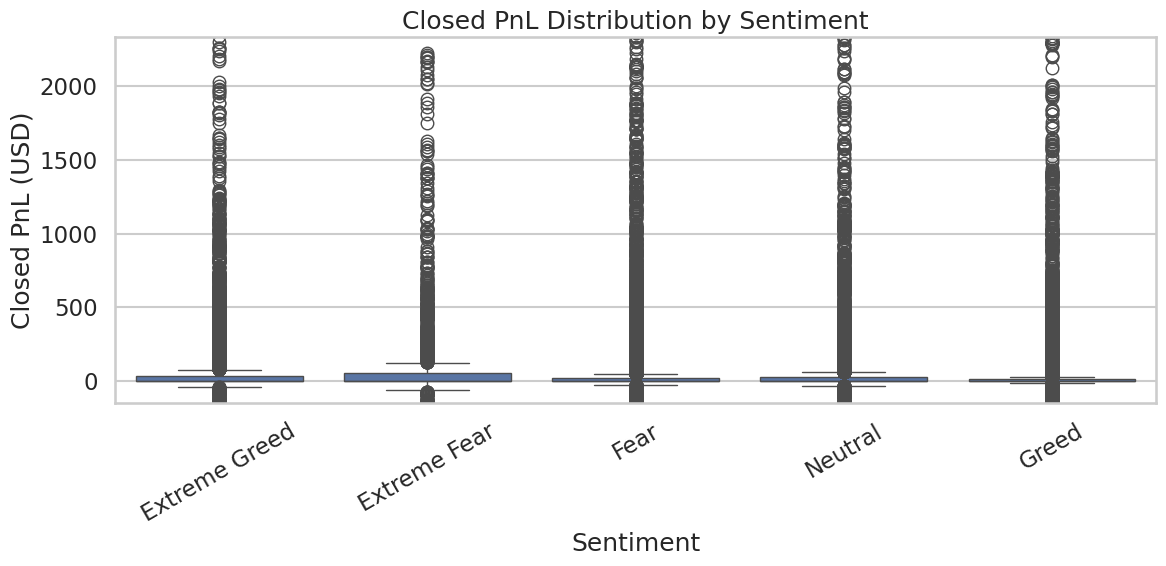

In [21]:
# 7B: Boxplot - distribution of closed_pnl by sentiment (log-transform may be helpful due to skew)
plt.figure(figsize=(12,6))
sns.boxplot(data=merged[merged['closed_pnl'].notnull()], x='fg_classification_mode', y='closed_pnl')
plt.title("Closed PnL Distribution by Sentiment")
plt.ylabel("Closed PnL (USD)")
plt.xlabel("Sentiment")
plt.ylim(merged['closed_pnl'].quantile(0.01), merged['closed_pnl'].quantile(0.99))  # zoom in to central 98%
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "boxplot_pnl_by_sentiment.png"))
plt.show()


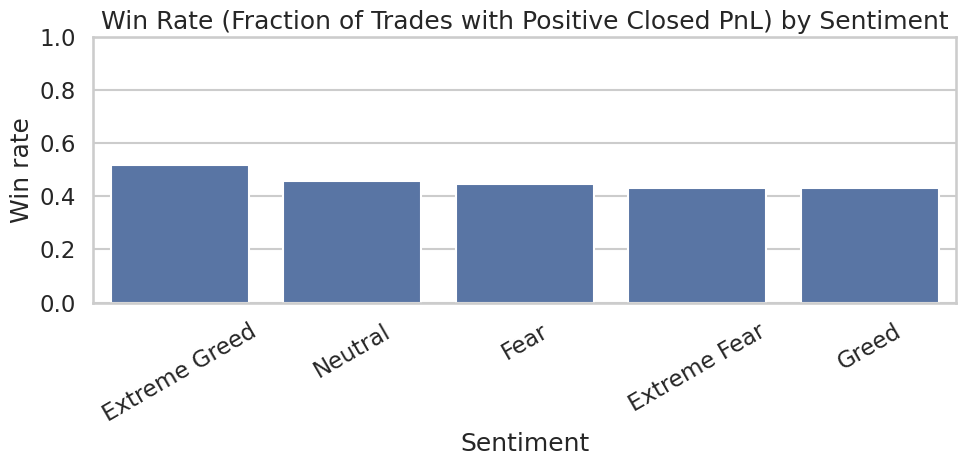

In [22]:
# 7C: Win rate by sentiment (percentage)
win_rate = merged.groupby('fg_classification_mode')['is_win'].mean().reset_index().sort_values('is_win', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=win_rate, x='fg_classification_mode', y='is_win')
plt.title("Win Rate (Fraction of Trades with Positive Closed PnL) by Sentiment")
plt.ylabel("Win rate")
plt.xlabel("Sentiment")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "win_rate_by_sentiment.png"))
plt.show()


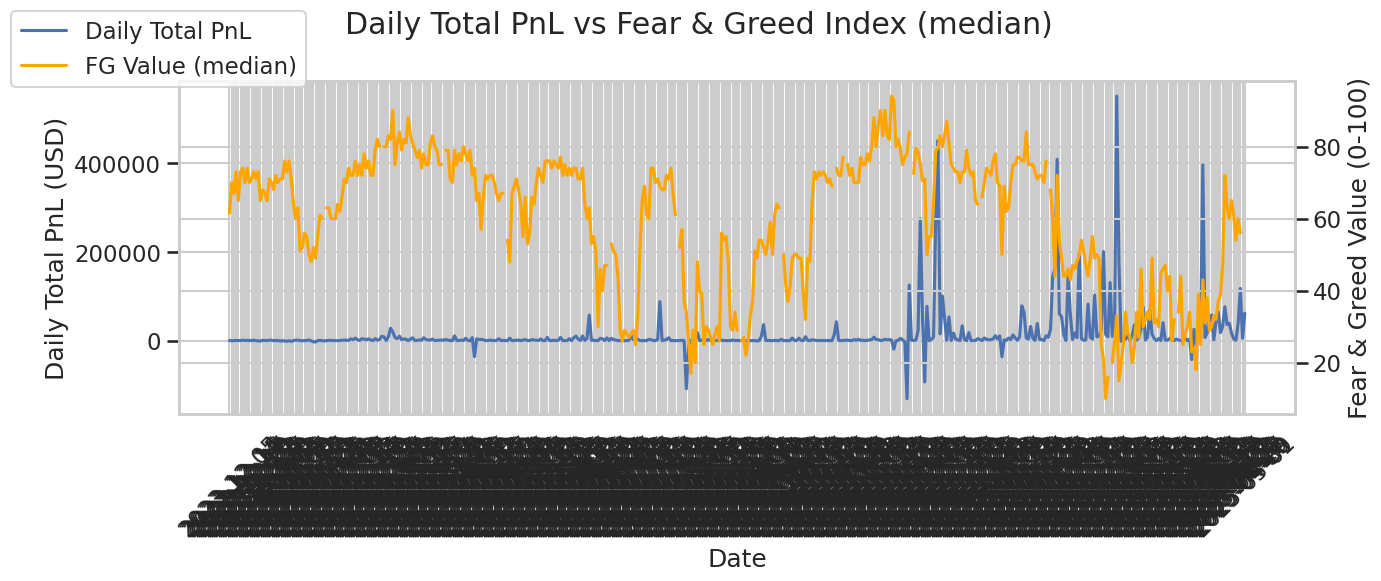

In [23]:
# 7D: Time series - daily total PnL vs daily sentiment value (merged daily aggregate)
daily_trade = merged.groupby('trade_date').agg(daily_total_pnl = ('closed_pnl','sum'),
                                               daily_avg_pnl = ('closed_pnl','mean'),
                                               daily_trade_count = ('closed_pnl','count')).reset_index()
# attach daily fg value from fg_daily
daily_trade = daily_trade.merge(fg_daily[['date','fg_value_median']], left_on='trade_date', right_on='date', how='left')

# Plot with dual axis
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(daily_trade['trade_date'], daily_trade['daily_total_pnl'], label='Daily Total PnL')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Total PnL (USD)')
ax1.tick_params(axis='y')
ax1.set_xticklabels(daily_trade['trade_date'], rotation=45)

ax2 = ax1.twinx()
ax2.plot(daily_trade['trade_date'], daily_trade['fg_value_median'], color='orange', label='FG Value (median)')
ax2.set_ylabel('Fear & Greed Value (0-100)')

fig.suptitle("Daily Total PnL vs Fear & Greed Index (median)")
fig.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "daily_pnl_vs_fg.png"))
plt.show()


Statistical testing

Example: Compare win rates between 'Fear' and 'Greed' using proportions test


In [39]:
from statsmodels.stats.proportion import proportions_ztest
# pick two groups: 'Fear' and 'Greed' (only if present)
g1 = merged[merged['fg_classification_mode']=='Fear']
g2 = merged[merged['fg_classification_mode']=='Greed']

print("Counts:", g1.shape[0], g2.shape[0])

if g1.shape[0] > 30 and g2.shape[0] > 30:
    count = np.array([g1['is_win'].sum(), g2['is_win'].sum()])
    nobs = np.array([g1.shape[0], g2.shape[0]])
    stat, pval = proportions_ztest(count, nobs)
    print("Proportions z-test stat:", stat, "p-value:", pval)
else:
    print("Not enough observations in one of the groups to run z-test reliably.")


Counts: 46883 53753
Proportions z-test stat: -14.018253555780623 p-value: 1.2054470136570137e-44


Simple predictive model: logistic regression to predict is_win (won trade)

Features: fg_value_median, side (BUY/SELL), trade_hour, size_usd (log)

This is illustrative — don't overinterpret


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Prepare model data (drop rows with missing target or fg_value)
model_df = merged.dropna(subset=['is_win','fg_value_median','size_usd']).copy()

# Simple feature engineering
model_df['side_buy'] = (model_df['side']=='BUY').astype(int)
model_df['log_size_usd'] = np.log1p(model_df['size_usd'])

feature_cols = ['fg_value_median','side_buy','trade_hour','log_size_usd']
X = model_df[feature_cols].fillna(0)
y = model_df['is_win']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Feature coefficients:")
for f,c in zip(feature_cols, clf.coef_.ravel()):
    print(f, c)


Classification report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65     19919
           1       0.53      0.66      0.59     14072

    accuracy                           0.62     33991
   macro avg       0.62      0.63      0.62     33991
weighted avg       0.64      0.62      0.62     33991

ROC AUC: 0.6411099867767471
Feature coefficients:
fg_value_median 0.06770842259898889
side_buy -0.5483731137561126
trade_hour 0.032779433660525485
log_size_usd -0.03881764302778601


Account-level analysis: top performers and their sentiment sensitivity


In [41]:
# Compute account-level metrics
if 'account' in merged.columns:
    acct_stats = merged.groupby('account').agg(
        trades=('closed_pnl','count'),
        total_pnl=('closed_pnl','sum'),
        avg_pnl=('closed_pnl','mean'),
        win_rate=('is_win','mean'),
        avg_trade_size=('size_usd','mean')
    ).reset_index().sort_values('total_pnl', ascending=False)

    display(acct_stats.head(10))

    # Check top accounts behaviour by sentiment
    top_accounts = acct_stats.head(5)['account'].tolist()
    top_merged = merged[merged['account'].isin(top_accounts)]
    acct_sent = top_merged.groupby(['account','fg_classification_mode']).agg(
        total_pnl=('closed_pnl','sum'),
        mean_pnl=('closed_pnl','mean'),
        win_rate=('is_win','mean'),
        trades=('closed_pnl','count')
    ).reset_index()
    display(acct_sent.pivot(index='fg_classification_mode', columns='account', values='mean_pnl'))
else:
    print("No 'account' column present; skipping account-level analysis.")


,account,trades,total_pnl,avg_pnl,win_rate,avg_trade_size
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,2.143383e+06,145.481748,0.337134,3837.885375
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1.600230e+06,419.127768,0.359612,16159.576734
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,21192,9.401638e+05,44.364091,0.467582,3210.472831
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,12236,8.404226e+05,68.684419,0.401193,34396.580284
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,8.360806e+05,20.806305,0.428230,1844.211886
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,4356,6.777471e+05,155.589314,0.486226,9084.699093
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,1590,4.293556e+05,270.034947,0.345912,7216.667245
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1237,4.165419e+05,336.735548,0.484236,2397.824753
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1430,4.030115e+05,281.826227,0.306294,2133.667364
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,9893,3.790954e+05,38.319560,0.810876,2600.778049


account,0x083384f897ee0f19899168e3b1bec365f52a9012,0x513b8629fe877bb581bf244e326a047b249c4ff1,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0xbaaaf6571ab7d571043ff1e313a9609a10637864,0xbee1707d6b44d4d52bfe19e41f8a828645437aab
fg_classification_mode,,,,,
Extreme Fear,527.147925,0.000000,3.909545,7.050661,-7.083126
Extreme Greed,-43.690169,0.000000,631.680991,NaN,114.707739
Fear,493.120165,60.067636,85.295744,8.120544,3.173998
Greed,-151.066687,80.358770,102.448586,239.420777,26.029489
Neutral,9668.216761,111.563965,18.722915,69.604949,14.405520


 Symbol-level analysis


In [42]:
if 'coin' in merged.columns:
    coin_stats = merged.groupby('coin').agg(
        trades=('closed_pnl','count'),
        total_pnl=('closed_pnl','sum'),
        mean_pnl=('closed_pnl','mean'),
        win_rate=('is_win','mean')
    ).reset_index().sort_values('total_pnl', ascending=False)
    display(coin_stats.head(15))
else:
    print("No coin column - skipping symbol analysis.")


,coin,trades,total_pnl,mean_pnl,win_rate
4,107,29992,2.783913e+06,92.821850,0.467591
137,HYPE,68005,1.948485e+06,28.652079,0.414999
205,SOL,10691,1.639556e+06,153.358519,0.394631
120,ETH,11158,1.319979e+06,118.298874,0.359921
105,BTC,26064,8.680447e+05,33.304356,0.350829
161,MELANIA,4428,3.903511e+05,88.155165,0.443993
117,ENA,990,2.173295e+05,219.524751,0.313131
210,SUI,1979,1.992688e+05,100.691680,0.423951
240,ZRO,1239,1.837778e+05,148.327509,0.367232
112,DOGE,826,1.475432e+05,178.623676,0.486683


Save processed merged dataset and summary tables for reporting


In [43]:
merged.to_csv(os.path.join(OUT_DIR, "merged_trades_with_fg.csv"), index=False)
summary_by_sent.to_csv(os.path.join(OUT_DIR, "summary_by_sentiment.csv"), index=False)
daily_trade.to_csv(os.path.join(OUT_DIR, "daily_trade_summary.csv"), index=False)
print("Saved outputs to", OUT_DIR)


Saved outputs to outputs
